# Compute diversity indices

In [3]:
%run "Header.ipynb"

In [4]:
import math
import json
import pysam
import pysamstats
import skbio
from matplotlib import pyplot

## Parameters of the diversity index: $p$ and $m$

See paper for description.

In [5]:
m = 5

# The possible values of p we'll try. These are NOT p-values so i'm not gonna call them that lmao
# We exclude p = 0 since computing m/0 is obviously uh not gonna work out
percentages = [50, 25, 10, 5, 2, 1, 0.5, 0.25, 0.1, 0.05]

# No edges with length < this will be included in the diversity index
MIN_SEQ_LEN = 1e6

## Compute diversity index for varying values of $p$

Note that not all genomes that pass the filter for one value of $p$ will pass the filter for other values of $p$. This is expected.

In [4]:
# This should include all edges' alignments now, not just the three selected genomes!
bf = pysam.AlignmentFile("../main-workflow/output/fully-filtered-and-sorted-aln.bam", "rb")

### Get a mapping of sequence (edge) name to sequence length

In [6]:
# Compute mapping of edge name to length -- need to know this for some of the computations below.
#
# We don't use skbio.DNA.read() for this since that seems to only return a single sequence from the
# FASTA file at once (it's configurable with the seq_num parameter, but I don't want to accidentally
# make this a "Schlemiel the Painter's" algorithm by first iterating to seq 1, then starting over and
# iterating to seq 2, and so on. Easiest to just handle this parsing from scratch.

seq2len = {}
seqname = None
with open("../main-workflow/output/all_edges.fasta", "r") as fastafile:
    
    # Assumes that sequences are not split up over multiple lines (so a FASTA file with N sequences
    # should have only 2N lines, maybe 2N + 1 if there's an extra empty newline at the bottom of the file)
    for linenum, line in enumerate(fastafile):
    
        if line.startswith(">"):
            if linenum % 2 != 0:
                raise ValueError("something weird with > location in all_edges.fasta. Go yell at Marcus.")
            seqname = line.strip()[1:]
        else:
            if linenum % 2 != 1:
                raise ValueError("something weird with non > location in all_edges.fasta. Go yell at Marcus.")
            if seqname is None:
                raise ValueError("No sequence name set yet?")
                
            seqlen = len(line.strip())
            seq2len[seqname] = seqlen
            seqname = None

print(f"seq2len contains {len(seq2len):,} entries. The length of edge_1 is {seq2len['edge_1']:,} bp.")

seq2len contains 78,793 entries. The length of edge_1 is 39,565 bp.


In [7]:
num_long_enough_seqs = 0
for seq in seq2len:
    if seq2len[seq] >= MIN_SEQ_LEN:
        num_long_enough_seqs += 1
print(f"{num_long_enough_seqs:,} / {len(seq2len):,} seqs have a length of at least {MIN_SEQ_LEN:,.0f} bp.")

468 / 78,793 seqs have a length of at least 1,000,000 bp.


### Actually compute the diversity indices

In [7]:
# Some stuff we precompute to avoid doing this a zillion times unnecessarily
p2pct = {p: p / 100 for p in percentages}
p2mincov = {p: m / p2pct[p] for p in percentages}

# The main results of this work will be saved here.
p2seq2dividx = {p: {} for p in percentages}

num_seqs = len(seq2len)

for si, seq in enumerate(seq2len.keys(), 1):
    pct = 100 * (si / num_seqs)
    print(f"On seq {seq} ({si:,} / {num_seqs:,}) ({pct:.2f}%)...", end=" ", flush=True)
    
    # Immediately ignore sequences with length < 1 Mbp.
    if seq2len[seq] < MIN_SEQ_LEN:
        print(f"Skipping since sequence length < {MIN_SEQ_LEN:,.0f} bp.")
        continue
    else:
        print(f"Length = {seq2len[seq] / 1e6:,.2f} Mbp.\n\tProgress:", end=" ", flush=True)
    
    # Keep track of how many positions in this sequence are sufficiently covered (the classification of a
    # position as sufficiently covered or not will depend on the value of p set).
    # We'll then use this to determine whether or not we can compute the diversity index for a sequence for
    # a given value of p.
    p2sufficientlycoveredpositionct = {p: 0 for p in percentages}
    
    # Numbers of identified p-mutations within just the sufficiently-covered positions for a given p for this
    # sequence.
    p2mutationct = {p: 0 for p in percentages}
    
    one_tenth_len = math.floor(seq2len[seq] / 10)
    
    # Go through each position in the sequence's pileup and look for sufficiently-covered positions and
    # p-mutations within those sufficiently-covered positions.
    #
    # See bam-to-jsons.py for a description of why these params are useful.
    for ri, rec in enumerate(
        pysamstats.stat_variation(
            bf, chrom=seq, fafile="../main-workflow/output/all_edges.fasta", start=0, end=seq2len[seq],
            truncate=True, pad=True, max_depth=1e6
        ),
        1
    ):
        # very simple progress bar for my own sake. might miss a few dots here and there
        if ri % one_tenth_len == 0:
            print("*", end="", flush=True)
            
        matches = rec["matches"]
        mismatches = rec["mismatches"]
        # NOTE: As with "coverage" in the coverage plots, this doesn't take into account deletions at a
        # given position. That info is available through pysamstats so we could use it here if desired.
        cov = matches + mismatches
        
        # Rather than looking at (mismatches / cov), we instead look at each alternate non-matching nucleotide
        # individually.
        nonmatches = set("ACGT") - set(rec["ref"])
        
        for p in percentages:
            if cov >= p2mincov[p]:
                p2sufficientlycoveredpositionct[p] += 1
                
                for nm in nonmatches:
                    if (rec[nm] / cov) > p2pct[p]:
                        p2mutationct[p] += 1
                        # Only count a given position once -- even if it contains multiple distinct p-mutations
                        # (e.g. if we set p = 1% and a given position has 95% reference [A], 2% C, 3% G,
                        # then that one position would only count as a single p-mutation).
                        #
                        # I guess this behavior could be changed if desired, although it would alter the
                        # interpretation of the diversity index since it'd no longer be constrained to [0, 1].
                        # (I guess the range would then be [0, 3]? Where a div index of 3 means that there are
                        # 3 p-mutations per reference position...? eesh.)
                        break
    
    print("")
    # Now that we've looked through all positions, see which value(s) of p we can compute the div index for
    # for this sequence. Do so, and save the resulting info.
    valid_p = []
    half_seq_len = 0.5 * seq2len[seq]
    for p in percentages:
        if p2sufficientlycoveredpositionct[p] >= half_seq_len:
            valid_p.append(p)
            dividx = p2mutationct[p] / p2sufficientlycoveredpositionct[p]
            p2seq2dividx[p][seq] = dividx
            print(f"\tDiv index for p = {p}%: ", dividx)
            
    print(f"\tDiversity index was defined for {len(valid_p)} / {len(percentages)} values of p: {valid_p}.")

On seq edge_1 (1 / 78,793) (0.00%)... Skipping since sequence length < 1,000,000 bp.
On seq edge_2 (2 / 78,793) (0.00%)... Skipping since sequence length < 1,000,000 bp.
On seq edge_3 (3 / 78,793) (0.00%)... Skipping since sequence length < 1,000,000 bp.
On seq edge_4 (4 / 78,793) (0.01%)... Skipping since sequence length < 1,000,000 bp.
On seq edge_5 (5 / 78,793) (0.01%)... Skipping since sequence length < 1,000,000 bp.
On seq edge_6 (6 / 78,793) (0.01%)... Skipping since sequence length < 1,000,000 bp.
On seq edge_7 (7 / 78,793) (0.01%)... Skipping since sequence length < 1,000,000 bp.
On seq edge_8 (8 / 78,793) (0.01%)... Length = 1.71 Mbp.
	Progress: **********
	Div index for p = 50%:  0.0
	Div index for p = 25%:  1.169563285069355e-05
	Div index for p = 10%:  0.0007212104589611868
	Div index for p = 5%:  0.001415430938798082
	Diversity index was defined for 4 / 10 values of p: [50, 25, 10, 5].
On seq edge_9 (9 / 78,793) (0.01%)... Skipping since sequence length < 1,000,000 bp.
On 

### Save the diversity index info to a file

Since this can take a few hours to compute, this helps if we have to restart the notebook halfway through / etc.

In [8]:
with open("misc-output/p2seq2dividx.json", "w") as jf:
    jf.write(json.dumps(p2seq2dividx))

## Visualize the diversity indices

As histograms sharing the same x-axes.

In [8]:
with open("misc-output/p2seq2dividx.json", "r") as jf:
    p2seq2dividx = json.load(jf)

In [9]:
# We compute these values since (as of writing) they're also computed for the CP 1/2/3 plots, etc. --
# however, no edges (again, as of writing) in the graph have coverage sufficient for these values. Assert this.
assert len(p2seq2dividx["0.1"]) == 0
assert len(p2seq2dividx["0.05"]) == 0

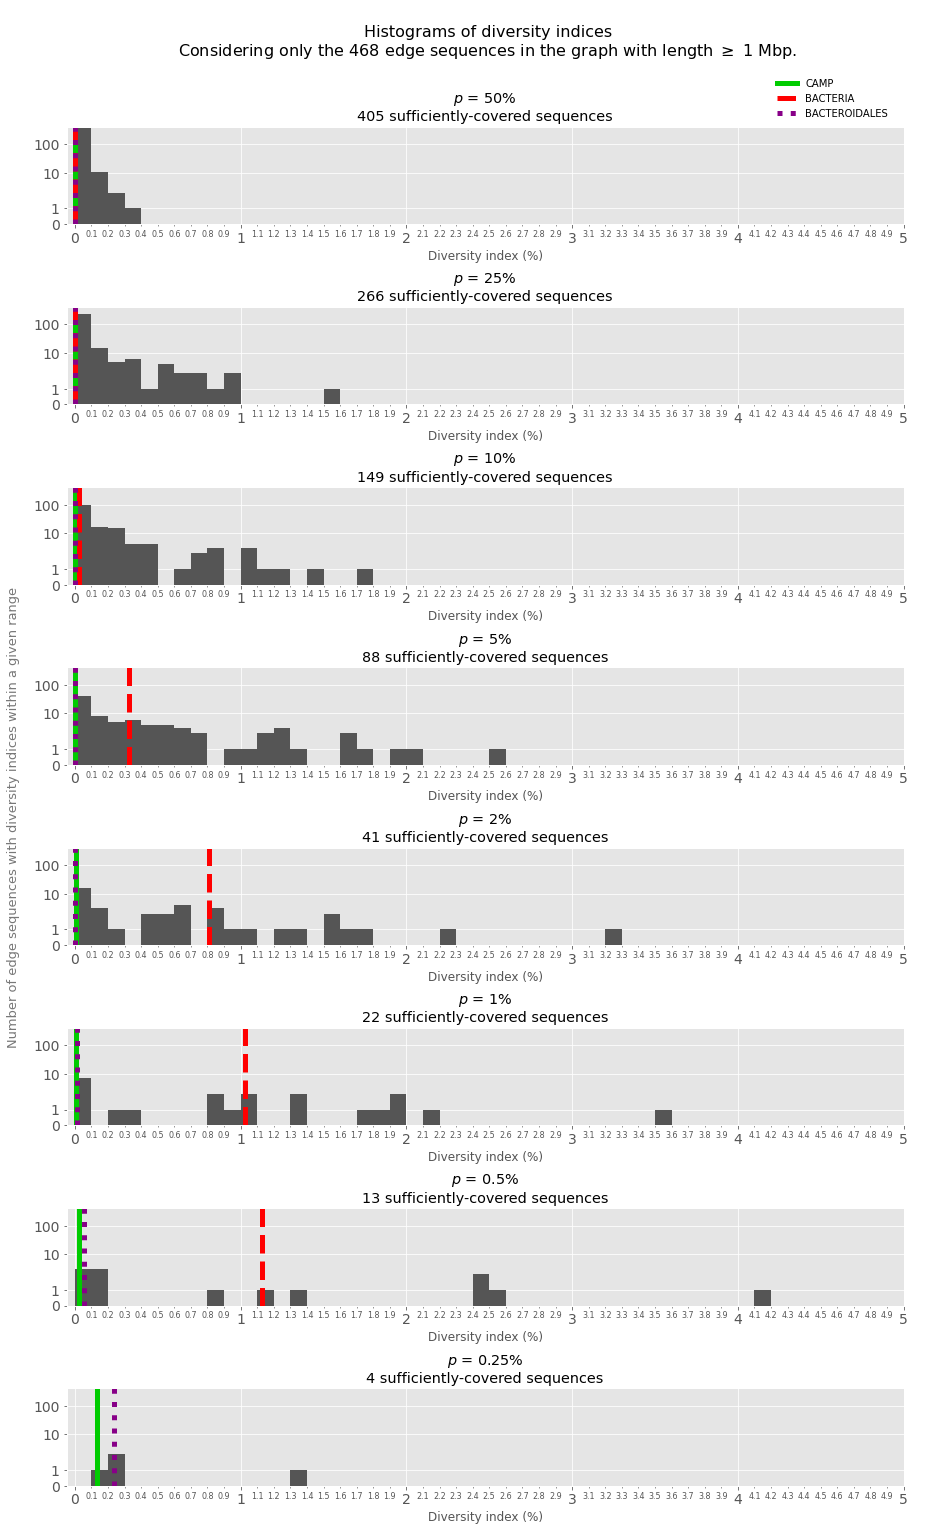

In [19]:
fig, axes = pyplot.subplots(len(percentages[:-2]), 1, sharey=True, gridspec_kw={"hspace": 0.85})

# matches the log-ratio plots and the cov/len summary plots
# TODO move to header notebook to avoid redundancy
seq2color = {"edge_6104": "#00cc00", "edge_1671": "#ff0000", "edge_2358": "#880088"}
seq2linestyle = {"edge_6104": "-", "edge_1671": "--", "edge_2358": ":"}

for pi, p in enumerate(percentages[:-2]):
    # We want bins to be identical and easy to compare between plots. So we use 50 bins, total:
    # 10 bins per percentage (so the first bin is [0%, 0.1%), the next is [0.1%, 0.2%), etc. up to [4.9%, 5%]).
    # range() doesn't support floating-point steps so we first get an integer range then convert this to a
    # range of floating-point vals.
    bins = [x / 10 for x in range(51)]
    
    axes[pi].hist(
        [100 * v for v in p2seq2dividx[str(p)].values()],
        color="#555555",
        bins=bins
    )
    axes[pi].set_ylim(0)
    axes[pi].set_xlim(-0.05, 5)
    axes[pi].set_yscale("symlog")
    
    # Don't write the axis numbers as 10^0, 10^1, etc. -- just write as 1, 10, etc.
    # https://stackoverflow.com/a/49751075
    axes[pi].yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    # Show nice tiny labels for increments of 0.1%.
    axes[pi].set_xticks(bins, minor=True)
    axes[pi].xaxis.set_minor_formatter("{x:.1f}")
    
    # Adjust the tick font sizes: https://stackoverflow.com/a/11386056
    # (Updating the y-axis as well as the x-axis is nice in that it automatically fixes the
    # problem where the y-axis used floating-point increments, which was unsightly in a frequency
    # histogram)
    axes[pi].tick_params(axis="both", which="major", labelsize=14)
    axes[pi].tick_params(axis="both", which="minor", labelsize=8)
    
    axes[pi].set_title(f"$p$ = {p}%\n{len(p2seq2dividx[str(p)])} sufficiently-covered sequences")
    axes[pi].set_xlabel("Diversity index (%)")
    for s in SEQS:
        if s in p2seq2dividx[str(p)]:
            label = seq2name[s] if pi == 0 else None
            axes[pi].axvline(
                x=p2seq2dividx[str(p)][s] * 100,
                color=seq2color[s],
                linewidth=5,
                linestyle=seq2linestyle[s],
                label=label
            )

# loc parameter is the lower-left corner of the legend, in "axes" coordinates. Don't ask.
fig.legend(loc=(0.82, 0.92), facecolor="white", edgecolor="white")
fig.set_size_inches(15, 25)

st = f"Histograms of diversity indices\nConsidering only the {num_long_enough_seqs} edge sequences in the graph with length $\geq$ 1 Mbp."
fig.suptitle(st, y=0.937, x=0.515, fontsize=16)

# y-axis label spanning multiple rows of plots; could probably do this more elegantly but this works so whatevs
# the color of #777777 is intended to match the x-axis labels' colors
fig.text(
    0.07, 0.37, "Number of edge sequences with diversity indices within a given range",
    rotation="vertical", fontsize="13", color="#777777"
)

fig.savefig("figs/diversity-indices.png", bbox_inches="tight")